# IMPORTS


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# CHARGEMENT DU DATASET


In [7]:
df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# NETTOYAGE DU DATAFRAME


In [8]:
df = df[['v1','v2']]
df = df.rename(columns={'v1':'label','v2':'text'})
df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# NETTOYAGE DU TEXTE


In [9]:
sw = set(stopwords.words('english'))
def clean_text(x):
    x = str(x).upper()
    x = re.sub(r'[^A-Z0-9 $€%]', ' ', x)
    tokens = x.split()
    tokens = [t for t in tokens if t.lower() not in sw]
    return ' '.join(tokens)
df['clean_text'] = df['text'].apply(clean_text)
df


,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",GO JURONG POINT CRAZY AVAILABLE BUGIS N GREAT ...
1,ham,Ok lar... Joking wif u oni...,OK LAR JOKING WIF U ONI
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,FREE ENTRY 2 WKLY COMP WIN FA CUP FINAL TKTS 2...
3,ham,U dun say so early hor... U c already then say...,U DUN SAY EARLY HOR U C ALREADY SAY
4,ham,"Nah I don't think he goes to usf, he lives aro...",NAH THINK GOES USF LIVES AROUND THOUGH
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2ND TIME TRIED 2 CONTACT U U 750 POUND PRIZE 2...
5568,ham,Will Ì_ b going to esplanade fr home?,B GOING ESPLANADE FR HOME
5569,ham,"Pity, * was in mood for that. So...any other s...",PITY MOOD SUGGESTIONS
5570,ham,The guy did some bitching but I acted like i'd...,GUY BITCHING ACTED LIKE INTERESTED BUYING SOME...


# EXPORT CLEAN CSV


In [10]:
df[['label','clean_text']].to_csv('../data/clean/spam_clean.csv', index=False)


# WORDCLOUD SPAM HAM


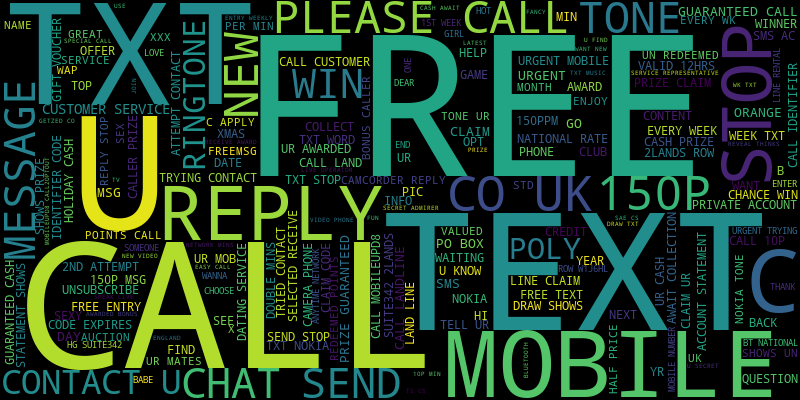

In [11]:
spam_text=' '.join(df[df['label']=='spam']['clean_text'])
ham_text=' '.join(df[df['label']=='ham']['clean_text'])
WordCloud(width=800,height=400).generate(spam_text).to_image()


# TOP TFIDF FEATURES


In [ ]:
tfidf_temp = TfidfVectorizer(ngram_range=(1,2))
X_temp = tfidf_temp.fit_transform(df['clean_text'])

feature_names = tfidf_temp.get_feature_names_out()

nb_temp = MultinomialNB().fit(X_temp, df['label'].map({'ham':0,'spam':1}))


spam_log_probs = nb_temp.feature_log_prob_[1]

top_idx = np.argsort(spam_log_probs)[-20:]
top_words = [feature_names[i] for i in top_idx]

top_words


['win',
 'contact',
 'service',
 'nokia',
 'new',
 '150p',
 'urgent',
 'uk',
 'cash',
 'www',
 'reply',
 'ur',
 'prize',
 'stop',
 'text',
 'claim',
 'mobile',
 'txt',
 'free',
 'call']

# EDA GRAPHIQUES


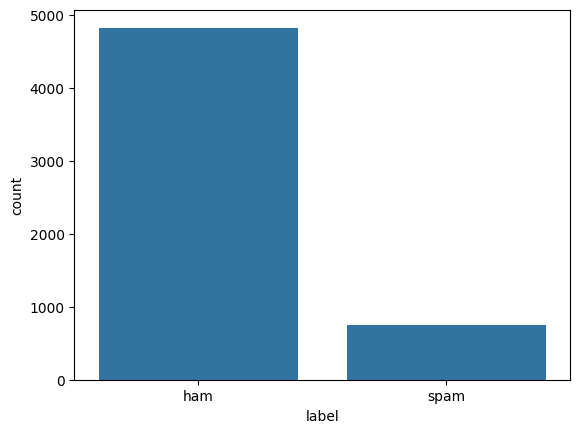

In [14]:
sns.countplot(x=df['label'])
plt.show()


# ENCODAGE DU LABEL


In [15]:
df['label_num']=df['label'].map({'ham':0,'spam':1})


# SPLIT TRAIN/TEST


In [16]:
X=df['clean_text']; y=df['label_num']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)


# TF-IDF


In [17]:
tfidf=TfidfVectorizer(ngram_range=(1,2))
X_train_t=tfidf.fit_transform(X_train)
X_test_t=tfidf.transform(X_test)


# NAIVE BAYES


In [18]:
nb=MultinomialNB().fit(X_train_t,y_train)
pred_nb=nb.predict(X_test_t)


# LOGISTIC REGRESSION


In [19]:
lr=LogisticRegression(max_iter=2000).fit(X_train_t,y_train)
pred_lr=lr.predict(X_test_t)


# SVM


In [20]:
svm=LinearSVC().fit(X_train_t,y_train)
pred_svm=svm.predict(X_test_t)


# COMPARAISON DES MODELES


In [21]:
scores={
 'NaiveBayes':accuracy_score(y_test,pred_nb),
 'LogReg':accuracy_score(y_test,pred_lr),
 'LinearSVM':accuracy_score(y_test,pred_svm)
}
scores


{'NaiveBayes': 0.9614349775784753,
 'LogReg': 0.9659192825112107,
 'LinearSVM': 0.9856502242152466}

# GRIDSEARCH


In [22]:
params={'C':[0.1,1,10]}
gs=GridSearchCV(LogisticRegression(max_iter=2000),params,cv=3)
gs.fit(X_train_t,y_train)
gs.best_params_


{'C': 10}

# GENERATION RESULT.TXT


In [23]:
with open('result.txt','w') as f:
    for k,v in scores.items(): f.write(f'{k}:{v}\n')
    f.write('BEST PARAM:' + str(gs.best_params_))
